# Abstract
The project aimed to detect malicious websites based on their URLs, utilizing a dataset from the Amazon Science fraud benchmark. Key features such as path depth, special character count, dash count, period count, and URL length were employed to classify maliciousness. The analysis incorporated Naive Bayes, logistic regression, and decision tree approaches, with the decision tree showing the most promising results. The subsequent phase involved revising and evaluating the machine learning model.

# Overview and Motivation
Malicious websites are a common source of cyber attacks, but automatically detecting if a new website is malicious often requires accessing the website first. Developing a heuristic to determine if a given URL is malicious has several benefits, improving speed and security in network administration, as user information does not need to be exposed as would happen when requesting website data to analyze.
The goal of this project is to develop a reasonably efficient and accurate method to determine if a URL from the URL alone.

# Related Work
Inspiration was drawn from the Amazon Science fraud benchmark dataset, providing a foundational framework for the analysis. Additionally, research into decision tree explainability guided efforts to comprehend the model's decision-making process. Particular use was made of the sixth chapter of *Hands-On Machine Learning with Scikit-Learn and TensorFlow*.

# Initial Questions
During the initial exploratory data analysis, I sought to answer the following questions:

* What patterns exist in the data?
* How can those patterns be leveraged to determine if a URL is malicious?
* Can these processes be done quickly?

As is explained in the EDA section, the answers to these questions informed the rest of the research, leading to quesitons that will be covered in the next sections.

# Data

MaliciousURLs Dataset (https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset/data) contains 651,191 URLs labeled by maliciousness category, making for a total of two columns for every row. The dataset is used as a part of Amazon Science's proposed FDB: Fraud Dataset Benchmark, as one of the nine different benchmarks which cover a wide variety of fraud benchmarks [ https://arxiv.org/pdf/2208.14417.pdf ].

In order ot extract features from the URLs three main methods were used. During the initial EDA, IP address inferral and spell checking were used, but the time cost of doing so was great enough that a subset of the data (every 100th row) was used. The size of the dataset is large enough that, in part inspired by works like *The Unreasonable Effectiveness of Data* [ https://ieeexplore.ieee.org/document/4804817 ], a faster feature extraction method based on parsing for special characters and simpler features  was used so that the entire dataset could be used in a resonable time frame.

# Exploratory Data Analysis

To make importing the data easier, Google Colab's drive functionality was used to directly import files from my Google Drive.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the CSV file in your Google Drive
folder = '/content/drive/My Drive/'
file_path = folder + 'malicious_phish.csv'

Mounted at /content/drive


In [ ]:
import pandas as pd
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)
print(f"df is {len(df)} rows long")

with pd.option_context('display.max_rows',10):
    print(df)

df is 651191 rows long
                                                      url        type
0                                        br-icloud.com.br    phishing
1                     mp3raid.com/music/krizz_kaliko.html      benign
2                         bopsecrets.org/rexroth/cr/1.htm      benign
3       http://www.garage-pirenne.be/index.php?option=...  defacement
4       http://adventure-nicaragua.net/index.php?optio...  defacement
...                                                   ...         ...
651186            xbox360.ign.com/objects/850/850402.html    phishing
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/    phishing
651188         www.gamespot.com/xbox360/action/deadspace/    phishing
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)    phishing
651190          www.angelfire.com/goth/devilmaycrytonite/    phishing

[651191 rows x 2 columns]


Category values can be converted to integers, making operations involving it faster. Lambda expressions have been used to make mapping the values cleaner. Duplicate and empty values have also been dropped, and the number of dropped values (10066 entries) was recorded.

In [ ]:
# For speed in processing the data, the categories should be converted to integers
category_values = {
    'benign':0,
    'defacement':1,
    'phishing':2,
    'malware':3
}
category_to_value = lambda x : category_values[x]
invert_dictionary = lambda x : {value : key for key, value in x.items()}
inv_category_values = invert_dictionary(category_values)

# Clean Data
clean_df = df.drop_duplicates().dropna()
print(f"A total of {len(df) - len(clean_df)} duplicate and/or empty rows were removed")
clean_df['type'] = clean_df['type'].apply(category_to_value)
with pd.option_context('display.max_rows',10):
    print(clean_df)

A total of 10066 duplicate and/or empty rows were removed
                                                      url  type
0                                        br-icloud.com.br     2
1                     mp3raid.com/music/krizz_kaliko.html     0
2                         bopsecrets.org/rexroth/cr/1.htm     0
3       http://www.garage-pirenne.be/index.php?option=...     1
4       http://adventure-nicaragua.net/index.php?optio...     1
...                                                   ...   ...
651186            xbox360.ign.com/objects/850/850402.html     2
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/     2
651188         www.gamespot.com/xbox360/action/deadspace/     2
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)     2
651190          www.angelfire.com/goth/devilmaycrytonite/     2

[641125 rows x 2 columns]


In the following function, he socket library's URL features have been used here in order to use the Domain Name System (DNS) lookup features, which converts the URL to an IP address. Initially, the numeric data seemed like it would be easier to parse, and also had several different immediately obvious features that could be extracted. Lambda expressions have also been written to account for inconsistent naming schemes in the data, working under the assumption that all URLs are using the HTTP protocol, which is reductive, but has proven experimentally to work well.

In [ ]:
import socket
from urllib.parse import urlparse

add_http = lambda x: "http://" + x if not x.startswith("http://") else x

def ip_from_url(url):
    try:
        # Parse the URL to get the hostname
        parsed_url = urlparse(add_http(url))
        hostname = parsed_url.hostname

        # Resolve the hostname to an IP address
        ip_address = socket.gethostbyname(hostname)
        return ip_address

    except (socket.gaierror, UnicodeError, AttributeError) as e:
        # Handle resolution errors, invalid URLs, or URLs without a hostname
        return None

In [ ]:
short_df = clean_df[::500]
len(short_df)

def find_ip_for_df(x):
  x['ip'] = x['url'].apply(ip_from_url)
  return x

augmented_df = find_ip_for_df(short_df).dropna()
augmented_df.to_csv(folder + 'malicious_phishing_augmented.csv', index=False)
# Data has been saved to Google Drive, which is where I will pull it from later.

<ipython-input-6-7337b79c1be2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['ip'] = x['url'].apply(ip_from_url)


The following function adds columns counting various types of symbols using Python's string library's built-in count function, (which will later be replaced with regular expressions in the machine learning section for ease of modification) with a lambda wrapping a list comprehension for a more complex task.

In [ ]:
import string

def parse_from_url_df(x):
  x['dashes'] = x['url'].str.count('-')
  x['periods'] = x['url'].str.count('\.')
  x['slashes'] = x['url'].str.count('/')
  x['symbols'] = clean_df['url'].apply(lambda x: len([c for c in x if c not in string.ascii_letters]))
  return x

parsed_df = parse_from_url_df(augmented_df)
print(augmented_df)

<ipython-input-7-12223368c573>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['dashes'] = x['url'].str.count('-')
<ipython-input-7-12223368c573>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['periods'] = x['url'].str.count('\.')
<ipython-input-7-12223368c573>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

                                                      url  type  \
500                                         imartial.com/     0   
1001    amazon.com/Inter-Municipal-Cooperation-Europe-...     0   
1502    artfact.com/auction-lot/ebac-homedry-880-dehum...     0   
2004    http://ap.org/Content/AP-In-The-News/2012/In-c...     0   
2504           elyrics.net/song/a/andrew-gold-lyrics.html     0   
...                                                   ...   ...   
648066                   sausage.web.tripod.com/isis.html     2   
648566   homepages.inf.ed.ac.uk/amos/opticalillusion.html     2   
650066                www.angelfire.com/home/storyte11er/     2   
650566  www.gamespot.com/ps2/action/disneysstitchexper...     2   
651066     www.eurogamer.net/article.php?article_id=59445     2   

                     ip  dashes  periods  slashes  symbols  
500        65.19.128.57       0        1        1        2  
1001       54.239.28.85       5        1        3       19  
1502      13

<ipython-input-7-12223368c573>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['symbols'] = clean_df['url'].apply(lambda x: len([c for c in x if c not in string.ascii_letters]))


The most complex predictor implemented in this phase of the project was spell-checking, which is a fairly intensive task, involving checking all words within a certain corrective 'distance' of a word to determine if there is at least a word in the pyspellchecker English dictionary that matches the word, and also how many words are mispelled. Total words (splitting at delimeters) and mispelled words are both tracked so that ratios can be considered. The largest concern here was false positives with brands that intentionally misspell a word, such as Lyft or Tumblr, which would be considered misspellings of Lift and Tumbler.

In [ ]:
! pip install pyspellchecker
from spellchecker import SpellChecker

# Initialize the spell checker with reduced Levenshtein distance
spell = SpellChecker(distance = 2)

def url_to_list(url):
    # Multi-Delimiter Split
    # https://www.geeksforgeeks.org/python-split-multiple-characters-from-string/
    delimiters = ["\/", ".", "-", "?", "="]
    for delimiter in delimiters:
       string = " ".join(url.split(delimiter))
    return string.split()

def count_total_words(url):
    return len(url_to_list(url))

def count_misspelled_words(url):
    count = 0
    for word in url_to_list(url):
        if not any(c.isalnum() for c in word):
            continue
        if not spell.correction(word) == word:
            count += 1
    return count

augmented_df['total_words'] = augmented_df['url'].apply(count_total_words)
augmented_df['misspelled_words'] = augmented_df['url'].apply(count_misspelled_words)
augmented_df.to_csv(folder + 'malicious_phishing_augmented2.csv', index=False)
# Data has been saved to Google Drive, which is where I will pull it from later.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 29.6 MB/s eta 0:00:00


<ipython-input-8-ba44948d18fe>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  augmented_df['total_words'] = augmented_df['url'].apply(count_total_words)
<ipython-input-8-ba44948d18fe>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  augmented_df['misspelled_words'] = augmented_df['url'].apply(count_misspelled_words)


This function converts an IP address into the HTTP class, as another feature that might yield interesting results.

In [ ]:
# Function to classify IP address into classes
def classify_ip(ip):
    first_octet = int(ip.split('.')[0])
    if 1 <= first_octet <= 126:
        return 'Class A'
    elif 128 <= first_octet <= 191:
        return 'Class B'
    elif 192 <= first_octet <= 223:
        return 'Class C'
    elif 224 <= first_octet <= 239:
        return 'Class D'
    elif 240 <= first_octet <= 255:
        return 'Class E'
    else:
        return 'Unknown'

# Apply the classification function to the IP addresses
augmented_df['ip_class'] = augmented_df['ip'].apply(classify_ip)

The subsets of the data based on maliciousness classes were selected and summarized in 5-number summaries below. The general takeaways were that the misspellings did seem significantly different between the classes, as well as general symbol usage.

In [ ]:
augmented_df = pd.read_csv(folder + 'malicious_phishing_augmented2.csv')

# Overall 5-number summary for integer-focused columns
overall_summary = augmented_df.describe()

# 5-number summary for integer-focused columns for benign rows
benign_summary = augmented_df[augmented_df['type'] == 0].describe()

# 5-number summary for integer-focused columns for malicious rows
malicious_summary = augmented_df[augmented_df['type'] != 0].describe()

# 5-number summary for integer-focused columns for each category
category_summaries = {}
for category in augmented_df['type'].unique():
    category_df = augmented_df[augmented_df['type'] == category]
    category_summaries[category] = category_df.describe()

# Print the summaries
print("Overall Summary:")
print(overall_summary)

print("\n5-Number Summary for Benign Rows:")
print(benign_summary)

print("\n5-Number Summary for Malicious Rows:")
print(malicious_summary)

for category, summary in category_summaries.items():
    print(f"\n5-Number Summary for Category '{inv_category_values[category]}':")
    print(summary)

Overall Summary:
              type       dashes      periods     slashes      symbols  \
count  1009.000000  1009.000000  1009.000000  1009.00000  1009.000000   
mean      0.466799     1.604559     1.992071     2.91774    12.986125   
std       0.832820     2.942778     1.090151     1.82307    13.256468   
min       0.000000     0.000000     1.000000     0.00000     1.000000   
25%       0.000000     0.000000     1.000000     2.00000     5.000000   
50%       0.000000     0.000000     2.000000     3.00000     9.000000   
75%       1.000000     2.000000     2.000000     4.00000    18.000000   
max       3.000000    19.000000    15.000000    14.00000   158.000000   

       total_words  misspelled_words  
count  1009.000000       1009.000000  
mean      1.412289          0.685828  
std       1.082182          1.000698  
min       1.000000          0.000000  
25%       1.000000          0.000000  
50%       1.000000          0.000000  
75%       1.000000          1.000000  
max       9.0

Various bin sizes were experimented with in the hopes that the nature of the histogram would not hide any interesting. Unfortunately, no patterns were evident, and the IP addresses appear randomly distributed.

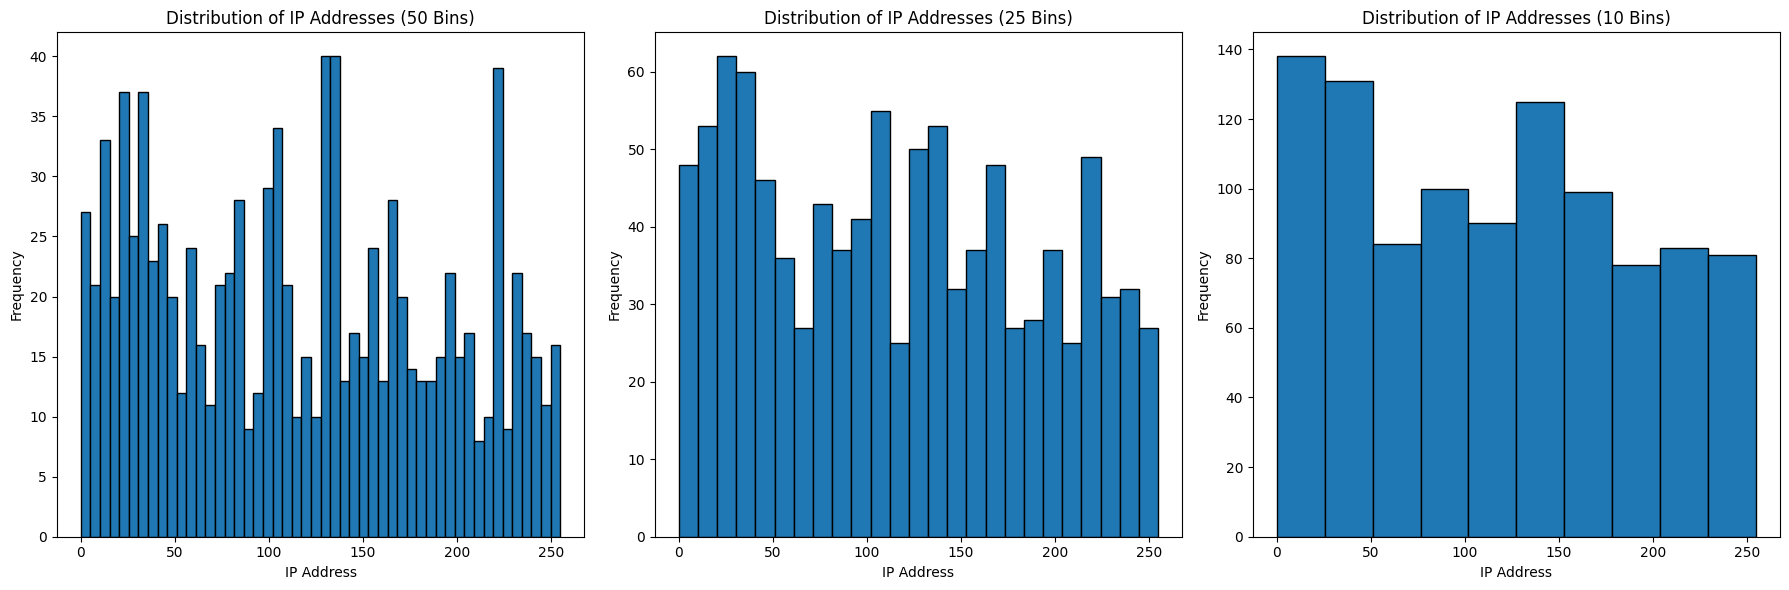

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Histogram of IP Addresses
ip_numeric = augmented_df['ip'].apply(lambda x: int(x.split('.')[-1]))
axes[0].hist(ip_numeric, bins=50, edgecolor='k')
axes[0].set_xlabel('IP Address')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of IP Addresses (50 Bins)')

# Plot 2: Bar Chart of Categories
axes[1].hist(ip_numeric, bins=25, edgecolor='k')
axes[1].set_xlabel('IP Address')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of IP Addresses (25 Bins)')

# Plot 3: Box Plot of Symbols
axes[2].hist(ip_numeric, bins=10, edgecolor='k')
axes[2].set_xlabel('IP Address')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution of IP Addresses (10 Bins)')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

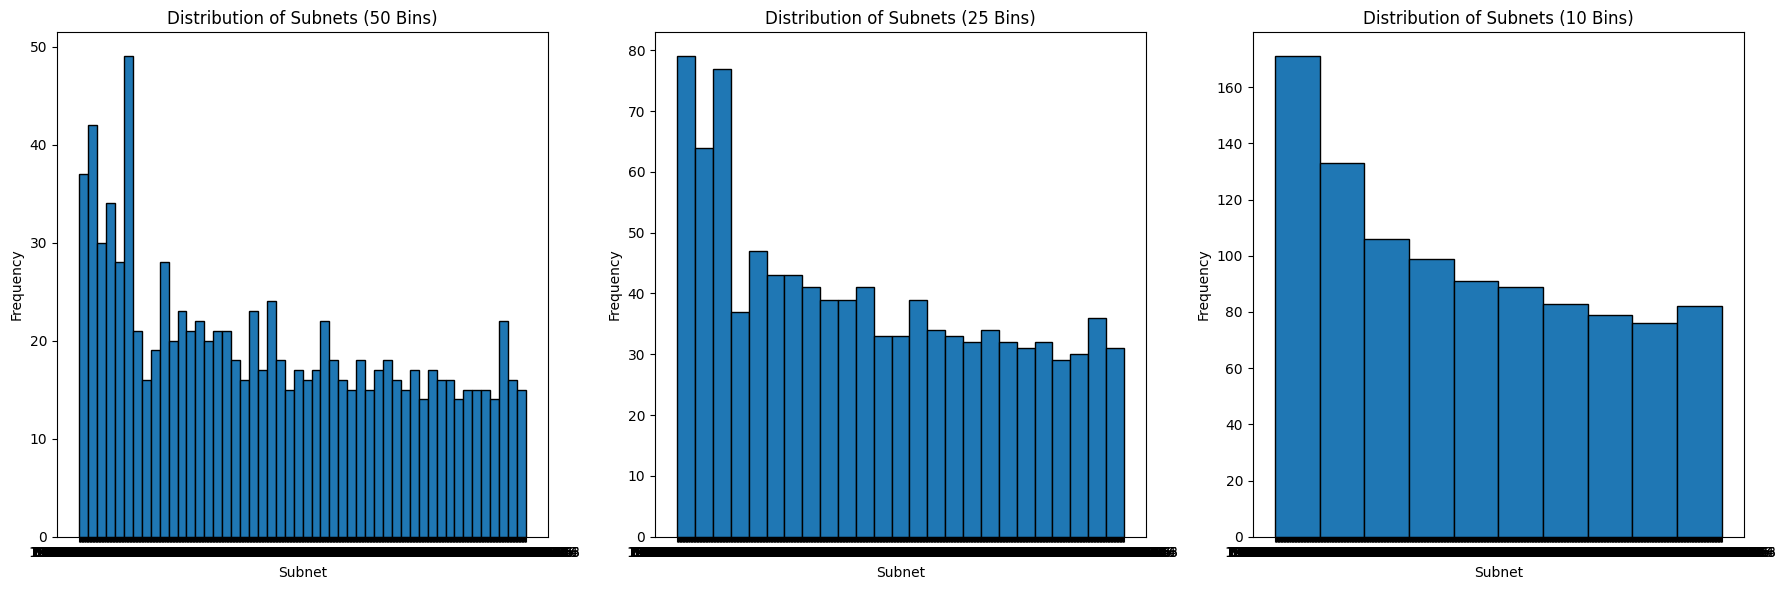

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress

# Extract subnets from IP addresses
augmented_df['subnet'] = augmented_df['ip'].apply(lambda x: str(ipaddress.IPv4Network(x, strict=False).network_address))

# Create three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Histogram of Subnets (50 Bins)
axes[0].hist(augmented_df['subnet'], bins=50, edgecolor='k')
axes[0].set_xlabel('Subnet')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Subnets (50 Bins)')

# Plot 2: Histogram of Subnets (25 Bins)
axes[1].hist(augmented_df['subnet'], bins=25, edgecolor='k')
axes[1].set_xlabel('Subnet')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Subnets (25 Bins)')

# Plot 3: Histogram of Subnets (10 Bins)
axes[2].hist(augmented_df['subnet'], bins=10, edgecolor='k')
axes[2].set_xlabel('Subnet')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution of Subnets (10 Bins)')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Most of the remaining visuals are pretty simple, technically speaking, but most of them boil down to a comparative approach in which "natural" patterns between the distinct labels of the classification problem are being searched for in a variety of variables.

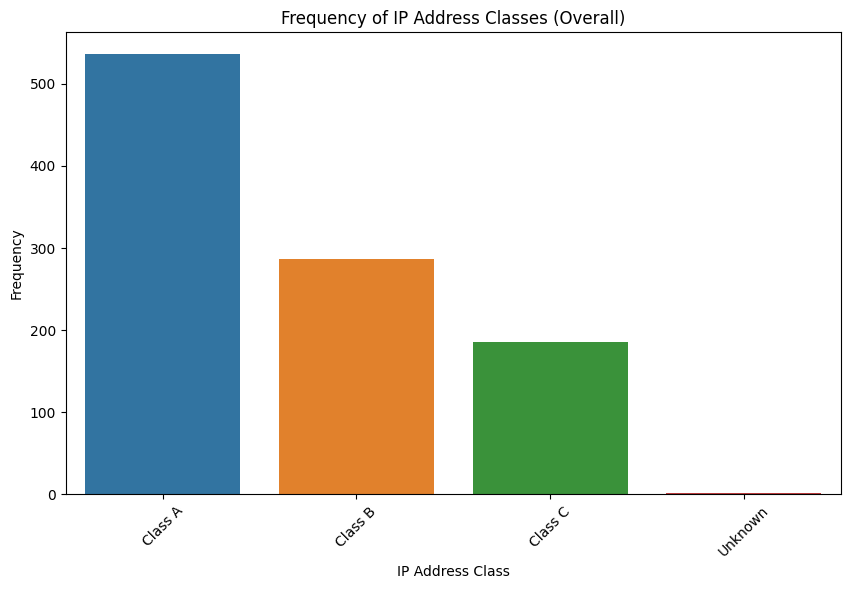

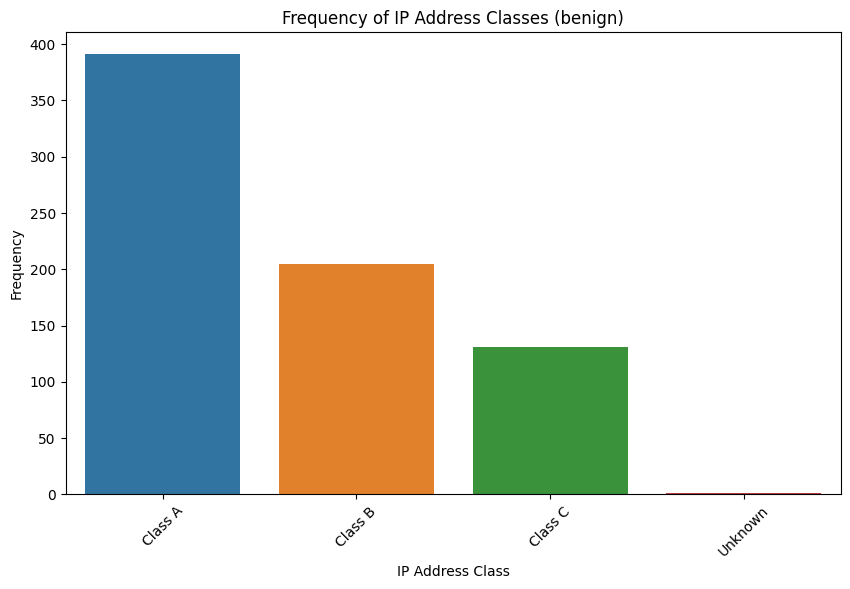

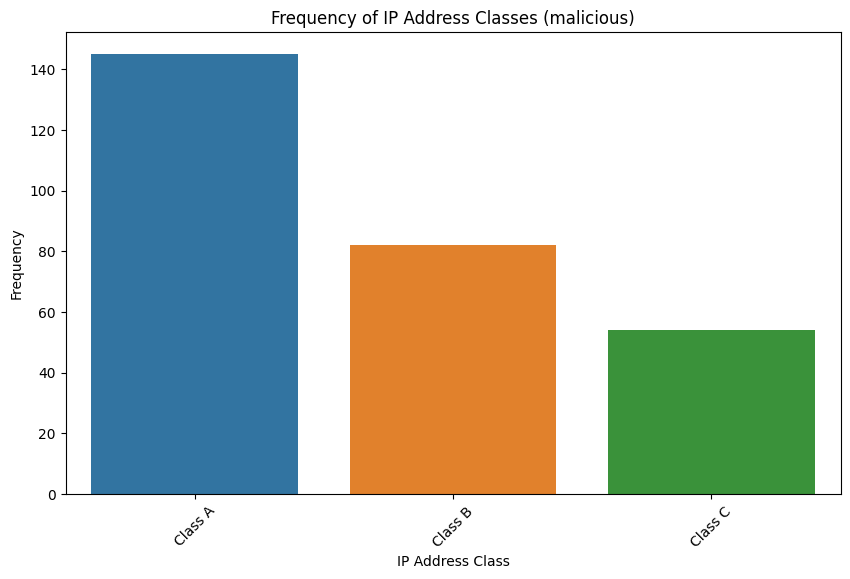

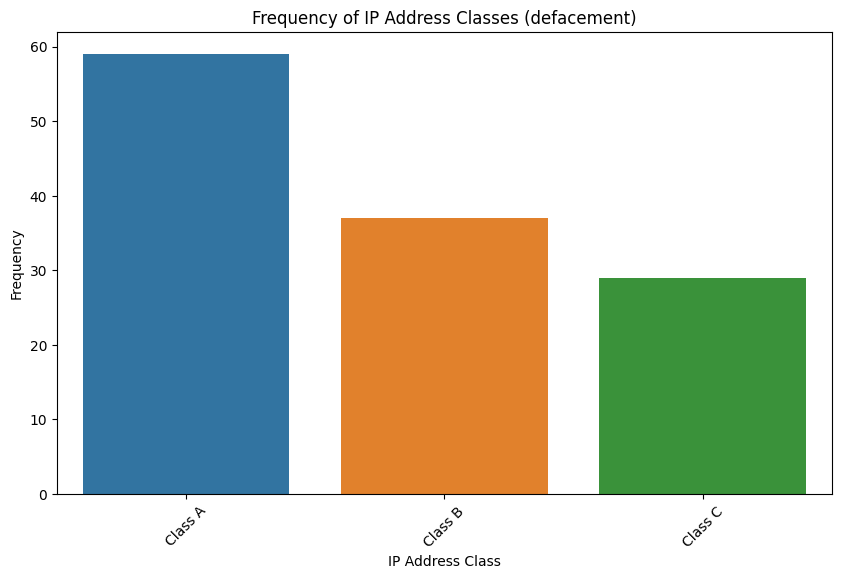

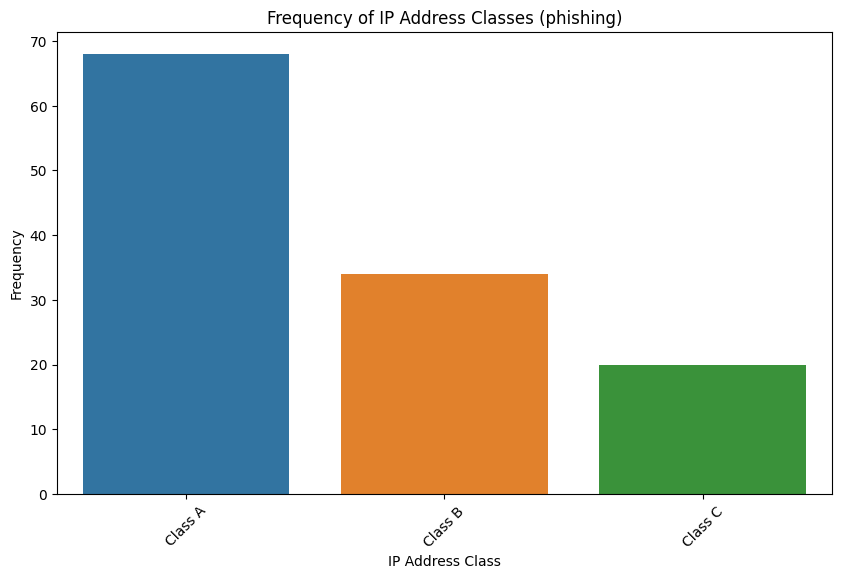

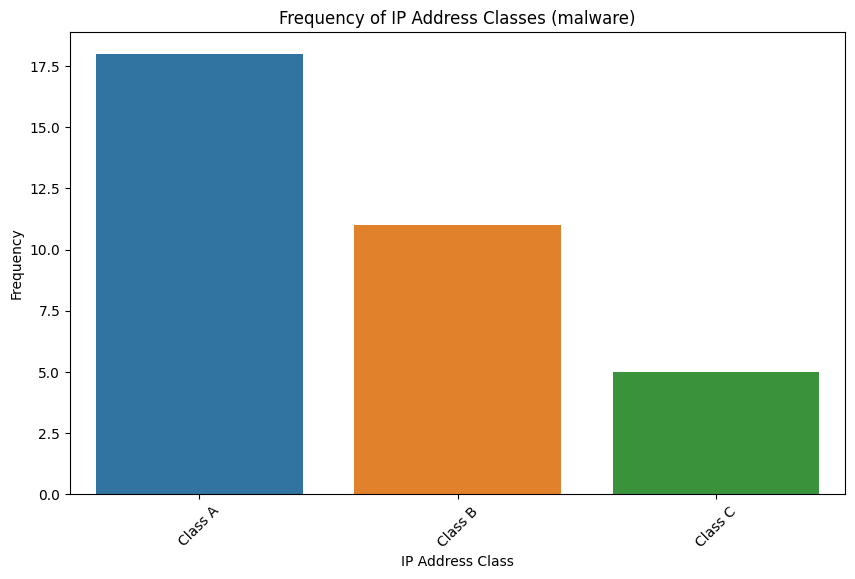

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def class_frequency(series, title):
    class_counts = series['ip_class'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.xlabel('IP Address Class')
    plt.ylabel('Frequency')
    plt.title(f'Frequency of IP Address Classes ({title})')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

class_frequency(augmented_df, 'Overall')
class_frequency(augmented_df[augmented_df['type'] == 0], 'benign')
class_frequency(augmented_df[augmented_df['type'] != 0], 'malicious')
class_frequency(augmented_df[augmented_df['type'] == 1], 'defacement')
class_frequency(augmented_df[augmented_df['type'] == 2], 'phishing')
class_frequency(augmented_df[augmented_df['type'] == 3], 'malware')

0       1
1       1
2       1
3       1
4       1
       ..
1004    1
1005    1
1006    1
1007    1
1008    2
Name: total_words, Length: 1009, dtype: int64


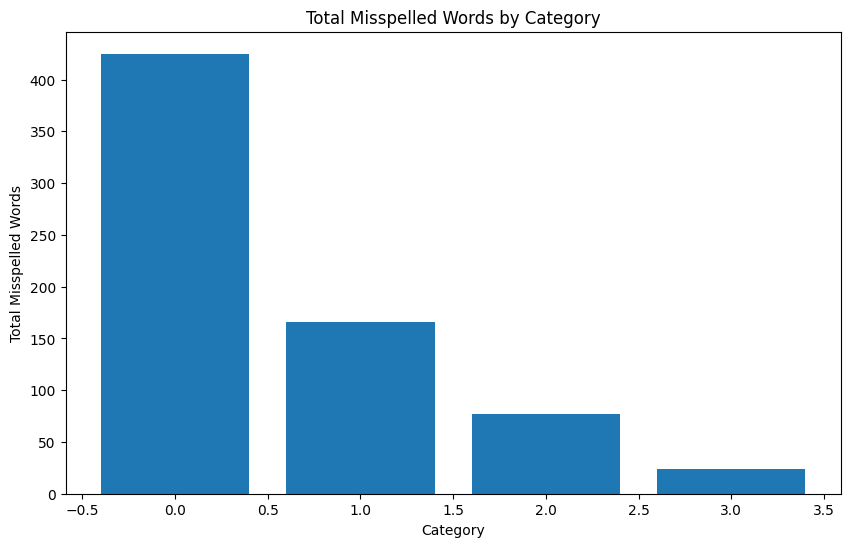

In [ ]:
print(augmented_df['total_words'])

# Group the data by the 'type' column and calculate the sum of misspelled words for each group
category_misspelled_counts = augmented_df.groupby('type')['misspelled_words'].sum().reset_index()

# Create a bar chart to visualize the sum of misspelled words in each category
plt.figure(figsize=(10, 6))
plt.bar(category_misspelled_counts['type'], category_misspelled_counts['misspelled_words'])
plt.xlabel('Category')
plt.ylabel('Total Misspelled Words')
plt.title('Total Misspelled Words by Category')
plt.show()

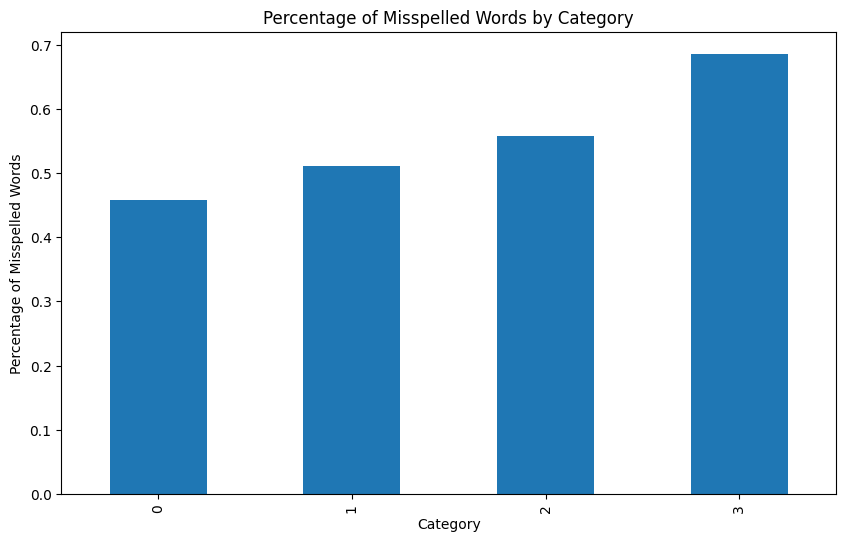

In [ ]:
# Group the data by the 'type' column and calculate the sum of misspelled words for each group
category_misspelled_counts = augmented_df.groupby('type')['misspelled_words'].sum()
category_total_counts = augmented_df.groupby('type')['total_words'].sum()
category_mispelled_percent = category_misspelled_counts / category_total_counts

# Create a bar chart to visualize the sum of misspelled words in each category
plt.figure(figsize=(10, 6))
category_mispelled_percent.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Percentage of Misspelled Words')
plt.title('Percentage of Misspelled Words by Category')
plt.show()

In the preliminary phase of EDA, attempts to infer IP addresses from URLs yielded inconclusive results and proved to be prohibitively time-consuming, thereby raising concerns about reliability. Moreover, the analysis revealed that checking for misspelled words in URLs exhibited promising potential for identifying malicious intent, but the process was too time-intensive. For instance, spell-checking a mere 500th of the dataset required nearly 30 minutes, posing practical challenges for scalability. As a more efficient alternative, easily extractable features such as the appearance of symbols emerged as a standout option. Consequently, the project is poised to shift focus onto leveraging these readily accessible features to develop a heuristic for URL-based malicious website detection in the next phase.

# Model Revision
Data munging for this portion of the project is just a streamlined version of what happened previously, now with regular expressions being used to check for a set of special characters, because it is more explicit in what it does. Path depth is now also being recorded, and adjusted to account for the two backslashes in the default HTTP protocol.

In [ ]:
# For speed in processing the data, the categories should be converted to integers
category_values = {
    'benign':0,
    'defacement':1,
    'phishing':2,
    'malware':3
}
category_to_value = lambda x : category_values[x]
invert_dictionary = lambda x : {value : key for key, value in x.items()}
inv_category_values = invert_dictionary(category_values)

# Clean Data
clean_df = df.drop_duplicates().dropna()
print(f"A total of {len(df) - len(clean_df)} duplicate and/or empty rows were removed")
clean_df['type'] = clean_df['type'].apply(category_to_value)

# Subtracting 2 to exclude the empty string and the root '/'
clean_df['malicious'] = clean_df['type'].apply(lambda x: 0 if x == 0 else 1)
clean_df['path_depth'] = clean_df['url'].apply(lambda x: max(len(x.split('/')) - 2, 0))


import re

def count_special_characters(url):
    special_chars_pattern = r'[!@#$%^&*()]'  # Define your pattern here
    return len(re.findall(special_chars_pattern, url))

clean_df['special_characters'] = clean_df['url'].apply(count_special_characters)
clean_df['length'] = clean_df['url'].apply(lambda x: len(x))
clean_df['dashes'] = clean_df['url'].str.count('-')
clean_df['periods'] = clean_df['url'].str.count('\.')

df = clean_df

with pd.option_context('display.max_rows',10):
    print(df)

A total of 10066 duplicate and/or empty rows were removed
                                                      url  type  malicious  \
0                                        br-icloud.com.br     2          1   
1                     mp3raid.com/music/krizz_kaliko.html     0          0   
2                         bopsecrets.org/rexroth/cr/1.htm     0          0   
3       http://www.garage-pirenne.be/index.php?option=...     1          1   
4       http://adventure-nicaragua.net/index.php?optio...     1          1   
...                                                   ...   ...        ...   
651186            xbox360.ign.com/objects/850/850402.html     2          1   
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/     2          1   
651188         www.gamespot.com/xbox360/action/deadspace/     2          1   
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)     2          1   
651190          www.angelfire.com/goth/devilmaycrytonite/     2          1   

     

The training split is 80/20 because the size of the data seemed to warrant a split with fewer tests proportionally, because the amount of testing data is still massive. A split_data function is used to make the actual manipulation of data cleaner for repeated trials.

In [ ]:
# Label Data
X = clean_df[['path_depth', 'special_characters', 'length', 'dashes', 'periods']]
y = clean_df['malicious']

from sklearn.model_selection import train_test_split

def split_data(data, target, test_size=0.2, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_val, y_train, y_val = split_data(X, y, random_state=1)

The Naive Bayes approach was used first due to its speed with large data to get a baseline accuracy. A Multinomial Naive Bayes approach using an alpha of 1.0, although varying the alpha value appeared to have no effect on the results. The test accuracy for the naive bayes approach was 69.68%.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB

alpha = 1.0
naive_bayes_classifier = MultinomialNB(alpha=alpha)
naive_bayes_classifier.fit(X_train, y_train)

# Validate the model on the validation set
y_val_pred = naive_bayes_classifier.predict(X_val)

# Assess the model's performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

# You can also use classification reports for more detailed performance metrics
classification_rep = classification_report(y_val, y_val_pred)
print(classification_rep)

Validation Accuracy: 0.6968
              precision    recall  f1-score   support

           0       0.77      0.79      0.78     85429
           1       0.55      0.52      0.53     42796

    accuracy                           0.70    128225
   macro avg       0.66      0.65      0.65    128225
weighted avg       0.69      0.70      0.69    128225



Logistic regression did not perform better than the Naive Bayes approach with the best test accuracy engine up at 69.17%.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression classifier
logistic_regression_classifier = LogisticRegression(random_state=1)

# Train the Logistic Regression model on the training data
logistic_regression_classifier.fit(X_train, y_train)

# Validate the Logistic Regression model on the validation set
y_val_pred_lr = logistic_regression_classifier.predict(X_val)

# Assess the model's performance
accuracy_lr = accuracy_score(y_val, y_val_pred_lr)
print(f'Logistic Regression Validation Accuracy: {accuracy_lr:.4f}')

# You can also use classification reports for more detailed performance metrics
classification_rep_lr = classification_report(y_val, y_val_pred_lr)
print(classification_rep_lr)

Logistic Regression Validation Accuracy: 0.6917
              precision    recall  f1-score   support

           0       0.70      0.93      0.80     85429
           1       0.60      0.22      0.33     42796

    accuracy                           0.69    128225
   macro avg       0.65      0.57      0.56    128225
weighted avg       0.67      0.69      0.64    128225



The decision tree approach performed much better even without any other tuning, achieving 84.15% accuracy.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree classifier
decision_tree_classifier = DecisionTreeClassifier(random_state=1)

# Train the Decision Tree model on the training data
decision_tree_classifier.fit(X_train, y_train)

# Validate the Decision Tree model on the validation set
y_val_pred_dt = decision_tree_classifier.predict(X_val)

# Assess the model's performance
accuracy_dt = accuracy_score(y_val, y_val_pred_dt)
print(f'Decision Tree Validation Accuracy: {accuracy_dt:.4f}')

# You can also use classification reports for more detailed performance metrics
classification_rep_dt = classification_report(y_val, y_val_pred_dt)
print(classification_rep_dt)

Decision Tree Validation Accuracy: 0.8415
              precision    recall  f1-score   support

           0       0.86      0.91      0.88     85429
           1       0.80      0.70      0.75     42796

    accuracy                           0.84    128225
   macro avg       0.83      0.81      0.82    128225
weighted avg       0.84      0.84      0.84    128225



[Text(0.42106771307626917, 0.9852941176470589, 'x[4] <= 2.5\ngini = 0.444\nsamples = 512900\nvalue = [342651, 170249]'),
 Text(0.14383055019270977, 0.9558823529411765, 'x[4] <= 1.5\ngini = 0.328\nsamples = 359684\nvalue = [285338, 74346]'),
 Text(0.03522231443126138, 0.9264705882352942, 'x[2] <= 20.5\ngini = 0.214\nsamples = 172041\nvalue = [151026, 21015]'),
 Text(0.00255655491959662, 0.8970588235294118, 'x[2] <= 15.5\ngini = 0.415\nsamples = 29537\nvalue = [20868, 8669]'),
 Text(0.0013534244441848694, 0.8676470588235294, 'x[3] <= 0.5\ngini = 0.464\nsamples = 12598\nvalue = [7980, 4618]'),
 Text(0.0009500447767005412, 0.8382352941176471, 'x[2] <= 14.5\ngini = 0.461\nsamples = 11768\nvalue = [7537, 4231]'),
 Text(0.0006042907759996885, 0.8088235294117647, 'x[0] <= 0.5\ngini = 0.468\nsamples = 9156\nvalue = [5735, 3421]'),
 Text(0.0002616516762060507, 0.7794117647058824, 'x[2] <= 6.5\ngini = 0.47\nsamples = 8985\nvalue = [5592, 3393]'),
 Text(9.967682903087646e-05, 0.75, 'x[2] <= 5.5\ng

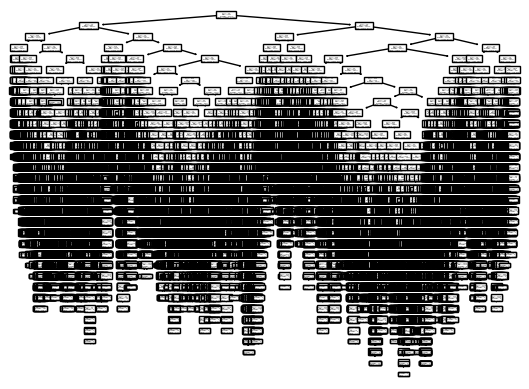

In [ ]:
from sklearn.tree import plot_tree
plot_tree(decision_tree_classifier)

The visualization of the decision tree was essentially unreadable due to the depth it ended up taking on and the way the nodes covered each other, but the first classifiers used were period count, length, and dashes.

# Full Analysis

The preliminary results indicated a validation accuracy of 84.15% for the decision tree. While Naive Bayes and logistic regression showed lower accuracies, they provided valuable baseline insights. The next steps involve fine-tuning the decision tree model, exploring feature selection, and delving into explainability for practical implementation in network administration.

Future steps include leveraging linear SVMs and unsupervised methods on a smaller subset of data due to computational complexity. Feature selection, particularly for the decision tree model, will play a pivotal role in enhancing performance. The primary challenge remains the computational intensity of certain methods, necessitating strategic data subset selection.

In summary, the project has progressed from initial data exploration to model development, with a focus on practicality and efficiency. The decision tree model has shown promise, and the forthcoming steps aim to refine and finalize the model for potential deployment in real-world cybersecurity applications.